In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
import time

In [2]:
spark = SparkSession.builder \
    .appName("KafkaToSpark") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0") \
    .getOrCreate()

24/04/15 19:19:51 WARN Utils: Your hostname, Mohits-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.5 instead (on interface en0)
24/04/15 19:19:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/mohitsaigutha/.ivy2/cache
The jars for the packages stored in: /Users/mohitsaigutha/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9a9ae307-f35a-4d66-8bce-5fb2d95f577d;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.3.0 in central


:: loading settings :: url = jar:file:/Users/mohitsaigutha/Library/Python/3.9/lib/python/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.3.0 in central
	found org.apache.kafka#kafka-clients;2.8.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.32 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.2 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.hadoop#hadoop-client-api;3.3.2 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 198ms :: artifacts dl 8ms
	:: modules in use:
	com.google.code.findbugs#jsr305;3.0.0 from central in [default]
	commons-logging#commons-logging;1.1.3 from central in [default]
	org.apache.commons#commons-pool2;2.11.1 from central in [default]
	org.apache.hadoop#hadoop-client-api;3.3.2 from central in [default]
	org.apache.hadoop#hadoop-client

In [3]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "44.201.154.178:9092") \
  .option("subscribe", "health_events") \
  .option("startingOffsets", "earliest") \
  .load()

24/04/15 19:20:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
schema = StructType([
    StructField("EventType", StringType()),
    StructField("Timestamp", TimestampType()),
    StructField("Location", StringType()),
    StructField("Severity", StringType()),
    StructField("Details", StringType())
])

In [6]:
df = df.selectExpr("CAST(value AS STRING)")  
df = df.select(from_json("value", schema).alias("data")).select("data.*")  

query = df.writeStream \
    .queryName("health_events_view") \
    .outputMode("append") \
    .format("memory") \
    .start()

time.sleep(90)
query.stop()

24/04/15 19:22:07 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/ws/_jcjzpkn43g4jn3yjvq6bcyh0000gn/T/temporary-61b9bf01-502f-4871-ac8a-a03b225eab17. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/04/15 19:22:07 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
24/04/15 19:22:08 WARN AdminClientConfig: The configuration 'key.deserializer' was supplied but isn't a known config.
24/04/15 19:22:08 WARN AdminClientConfig: The configuration 'value.deserializer' was supplied but isn't a known config.
24/04/15 19:22:08 WARN AdminClientConfig: The configuration 'enable.auto.commit' was supplied but isn't a known config.
24/04/15 19:22:08 WARN AdminClientConfig: The configuration '

In [7]:
df= spark.sql("SELECT * FROM health_events_view")
df.show(15)

+------------------+-------------------+-----------+--------+--------------------+
|         EventType|          Timestamp|   Location|Severity|             Details|
+------------------+-------------------+-----------+--------+--------------------+
|   routine_checkup|2024-04-03 02:14:33|      Paris|     low|This is a simulat...|
|emergency_incident|2024-04-03 02:14:52|     Boston|    high|This is a simulat...|
|hospital_admission|2024-04-03 02:15:12|Los Angeles|  medium|This is a simulat...|
|emergency_incident|2024-04-03 02:15:29|Los Angeles|    high|This is a simulat...|
|   routine_checkup|2024-04-03 02:15:47|      Paris|     low|This is a simulat...|
|       vaccination|2024-04-03 02:15:47|Los Angeles|     low|This is a simulat...|
|hospital_admission|2024-04-03 02:15:57|     Boston|    high|This is a simulat...|
|   routine_checkup|2024-04-03 02:16:06|     Berlin|     low|This is a simulat...|
|    health_mention|2024-04-03 02:16:10|   New York|     low|This is a simulat...|
|hos

24/04/15 19:23:38 WARN TaskSetManager: Stage 8 contains a task of very large size (1415 KiB). The maximum recommended task size is 1000 KiB.


In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

In [9]:
df_pandas=df.toPandas()

In [10]:
df_pandas.head()

,EventType,Timestamp,Location,Severity,Details
0,routine_checkup,2024-04-03 02:14:33,Paris,low,This is a simulated routine_checkup event.
1,emergency_incident,2024-04-03 02:14:52,Boston,high,This is a simulated emergency_incident event.
2,hospital_admission,2024-04-03 02:15:12,Los Angeles,medium,This is a simulated hospital_admission event.
3,emergency_incident,2024-04-03 02:15:29,Los Angeles,high,This is a simulated emergency_incident event.
4,routine_checkup,2024-04-03 02:15:47,Paris,low,This is a simulated routine_checkup event.


24/04/15 19:23:40 WARN TaskSetManager: Stage 9 contains a task of very large size (1415 KiB). The maximum recommended task size is 1000 KiB.
24/04/15 19:23:41 WARN TaskSetManager: Stage 12 contains a task of very large size (1415 KiB). The maximum recommended task size is 1000 KiB.
24/04/15 19:23:41 WARN TaskSetManager: Stage 15 contains a task of very large size (1415 KiB). The maximum recommended task size is 1000 KiB.


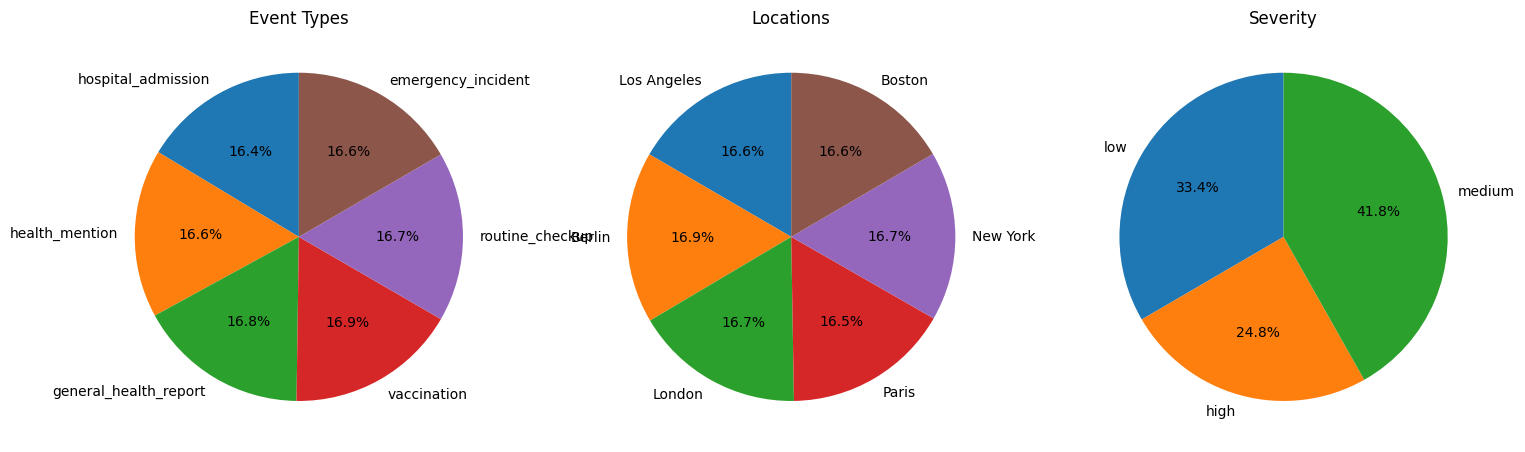

In [11]:
event_type_counts = df.groupBy("EventType").count().collect()
location_counts = df.groupBy("Location").count().collect()
severity_counts = df.groupBy("Severity").count().collect()

event_type_labels, event_type_values = zip(*[(row["EventType"], row["count"]) for row in event_type_counts])
location_labels, location_values = zip(*[(row["Location"], row["count"]) for row in location_counts])
severity_labels, severity_values = zip(*[(row["Severity"], row["count"]) for row in severity_counts])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].pie(event_type_values, labels=event_type_labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Event Types')

axes[1].pie(location_values, labels=location_labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Locations')

axes[2].pie(severity_values, labels=severity_labels, autopct='%1.1f%%', startangle=90)
axes[2].set_title('Severity')

plt.show()

24/04/15 19:23:42 WARN TaskSetManager: Stage 18 contains a task of very large size (1415 KiB). The maximum recommended task size is 1000 KiB.


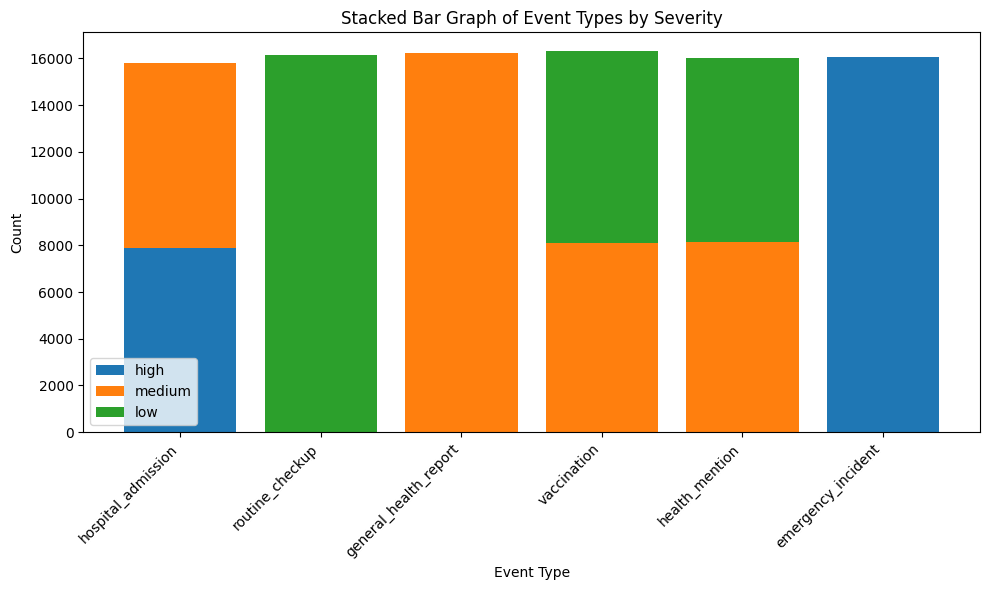

In [12]:
event_severity_counts = df.groupBy("EventType", "Severity").count().collect()

severity_counts_by_event = {}
for row in event_severity_counts:
    event_type = row["EventType"]
    severity = row["Severity"]
    count = row["count"]
    if event_type not in severity_counts_by_event:
        severity_counts_by_event[event_type] = {"high": 0, "medium": 0, "low": 0}
    severity_counts_by_event[event_type][severity] = count

event_types = list(severity_counts_by_event.keys())
severity_counts = list(severity_counts_by_event.values())

plt.figure(figsize=(10, 6))
severity_labels = ["high", "medium", "low"]
bar_width = 0.35
bottom = [0] * len(event_types)

for i, severity in enumerate(severity_labels):
    counts = [severity_count[severity] for severity_count in severity_counts]
    plt.bar(event_types, counts, label=severity, bottom=bottom)
    bottom = [bottom[j] + counts[j] for j in range(len(event_types))]

plt.xlabel('Event Type')
plt.ylabel('Count')
plt.title('Stacked Bar Graph of Event Types by Severity')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

/var/folders/ws/_jcjzpkn43g4jn3yjvq6bcyh0000gn/T/ipykernel_17788/2776292494.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


/var/folders/ws/_jcjzpkn43g4jn3yjvq6bcyh0000gn/T/ipykernel_17788/290497938.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


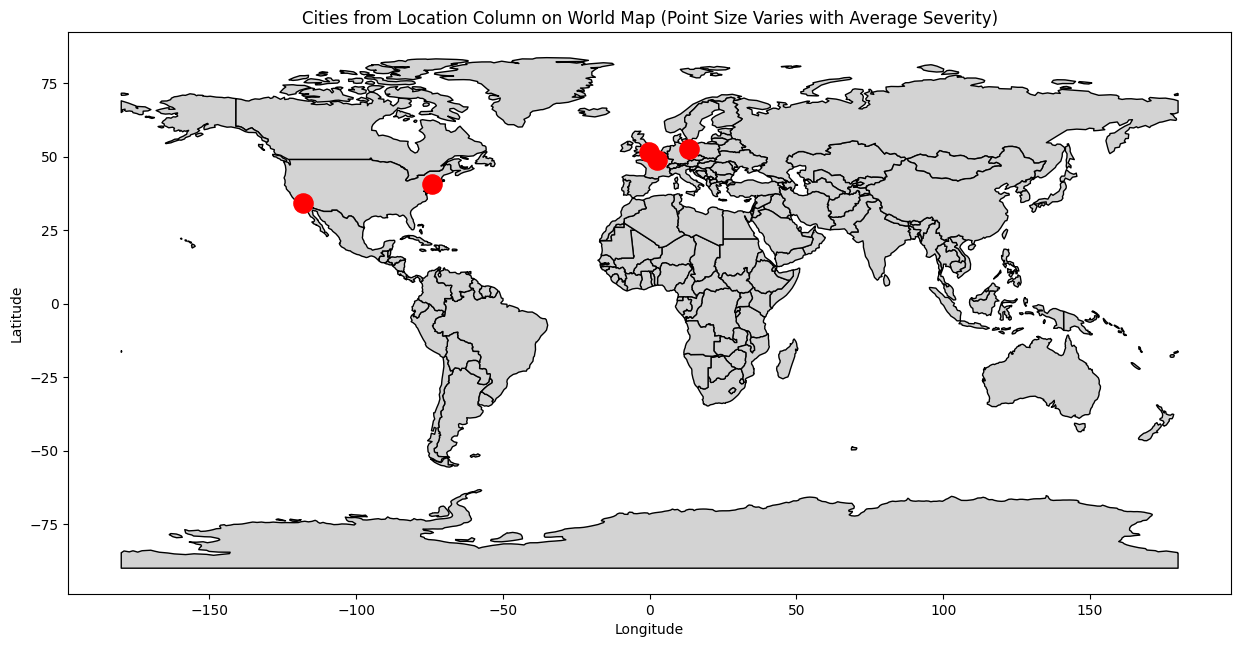

In [24]:
severity_values = {'high': 3, 'medium': 2, 'low': 1}

df_pandas['Severity_Value'] = df_pandas['Severity'].map(severity_values)

city_avg_severity = df_pandas.groupby('Location')['Severity_Value'].mean()

cities_filtered = cities[cities['name'].isin(city_avg_severity.index)]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

for index, row in cities_filtered.iterrows():
    city_name = row['name']
    if city_name in city_avg_severity:
        avg_severity = city_avg_severity[city_name]
        size = avg_severity * 100  
        ax.scatter(row['geometry'].x, row['geometry'].y, s=size, color='red')

plt.title('Cities from Location Column on World Map (Point Size Varies with Average Severity)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [25]:
for city, avg_severity in city_avg_severity.items():
    print(f"City: {city}, Average Severity: {avg_severity:.2f}")

City: Berlin, Average Severity: 1.92
City: Boston, Average Severity: 1.92
City: London, Average Severity: 1.91
City: Los Angeles, Average Severity: 1.91
City: New York, Average Severity: 1.91
City: Paris, Average Severity: 1.92


In [1]:
from pyspark.sql.functions import hour, dayofweek, date_format

df = spark.sql("""
    SELECT *,
           HOUR(Timestamp) AS hour,
           UPPER(DATE_FORMAT(Timestamp, 'EEE')) AS day
    FROM health_events_view
""")

df.show(15)

NameError: name 'df' is not defined

24/04/15 20:48:37 WARN TaskSetManager: Stage 42 contains a task of very large size (1415 KiB). The maximum recommended task size is 1000 KiB.


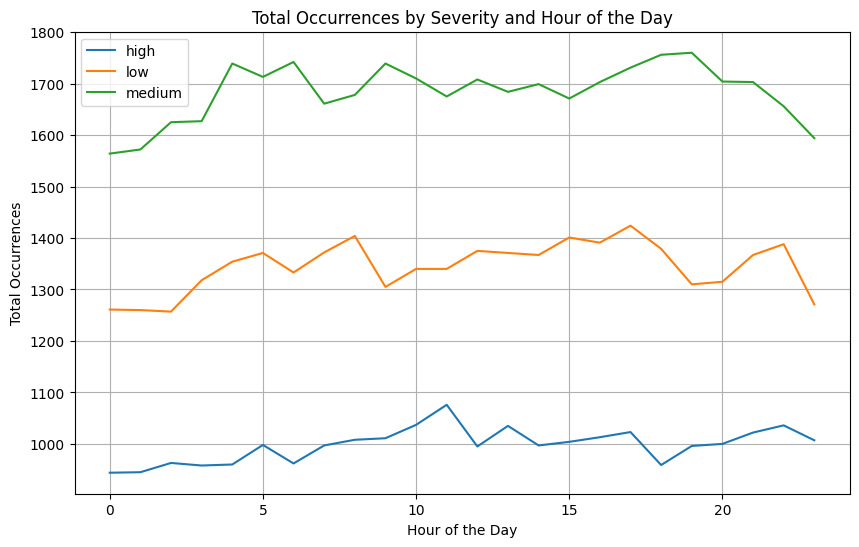

In [33]:
severity_hour_counts = df.groupBy("Severity", "hour").count().orderBy("Severity", "hour")

severity_hour_df = severity_hour_counts.toPandas()

plt.figure(figsize=(10, 6))

for severity in severity_hour_df['Severity'].unique():
    severity_data = severity_hour_df[severity_hour_df['Severity'] == severity]
    plt.plot(severity_data['hour'], severity_data['count'], label=severity)

plt.xlabel('Hour of the Day')
plt.ylabel('Total Occurrences')
plt.title('Total Occurrences by Severity and Hour of the Day')
plt.legend()
plt.grid(True)
plt.show()